In [64]:
%load_ext autoreload
%autoreload 2

import meep as mp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from itertools import product
from math import pi
print(mpl.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.1


In [65]:
# %conda install numpy matplotlib seaborn 

## Fields in a waveguide

1) ერთი ვორტიქსის სიგრძე, ანუ ჩვენს შემთხვევაში კვადრატის სიგრძე, ანუ h არის დაახლოვებით 10 ნანომეტრი.

2) Q პარამეტრი დაივიწყეთ. რაც გვიწერია სტატიაში omega/c*Q ეს იგივეა რაც h/lambda. lambda კი თავის მხრივ სიხშირეზეა დამოკიდებული.
თუ მაგალითად აიღებთ ჩვენს შემთხვევაში როგორც ჩვენის შედეგების ნახაზზეა, მაგალითად, განუზომელ პარამეტრს 0.53, ეს ნიშნავს, რომ h/lambda=0.53
ანუ თუ ვიცით, რომ  h=10 ნმ, ესეიგი ლამბდა არის 10/0.53=18.8679 ნმ. შესაბამისად შეგიძლიათ აქედან გაიგოთ სიხშირე, თუმცა არ მგონია რომ
სიხშირის გაგება გჭირდებოდეთ, მგონია რომ პერიოდი და ტალღის სიგრძე საკმარისია. 

ჯერ ნახეთ  h/lambda=0.53 და  h/lambda=0.58, სადაც ნამდვილად გასვლა გვაქვს. ამას იმიტომ ვამბობ, რომ არეკვლის სიმძლავრე დამოკიდებულია
ფენების რაოდენომაზე (როგორც ფოტონიკებში გვქონდა, 5-ს რომ ვიღებდით), შესაბამისად მე უნდა დავთვალო თქვენ რამდენ ფენასაც აიღებთ იქ
რამდენად ძლიერი იქნება არეკვლა. არეკვლა რომ იქნება ცხადია, თუმცა რამდენად ძლიერი, შეიძლება ნაწილი გავიდეს. 
რაც შეეხება h/lambda=0.53 და  h/lambda=0.58 აქ სრული გასვლაა და პრობლემა არ არის. 

მარტივია, მაგრამ მაინც იხილეთ ბმული ფაილი. ამ მარტივი გარდაქმნით პირდაპირ გამოდის 9.21 ფორმულა.
ანუ დროით ორმაგი წარმოებულები ჩაწერილი ამ ფორმით. აქედან პირდაპი 9.21.
თუ ახლა, უბრალოდ შესამოწმებლად, დაუშვებთ რომ ომეგა_დ=0 (გამმა_დ ყოველთვის ნულია ჩვენთან რადგანაც მილევა არ გვაქვს),
მიიღებთ დროის ყველა ეტაპზე ცნობილ დამოკიდებულებას D და E ვექტორებს შორის, კერძოდ D=eps_0*eps*E.
მოკლედ მე თითქმის დარწმუნებული ვარ, რომ თუ თქვენ სწორედ 
გამოიყენებთ ამ 9.21 ფორმულას, უნდა გადაიჭრას ჩვენი პრობლემა. ასევე ყურადღება მიაქციეთ სულ ბოლო წინადადებას
გაყვითლებული რომ მაქვს, სადაც რეალურად წერია რა მონაცემებით უნდა გააკეთოთ "აპდეითი" ახალი მონაცემების.
მოკლედ ერთი დამეტებითი D ვექტორის შემოტანა მოგიწევთ.


In [66]:
# scale is nanometers
# unit of distance is 1nm
width = 1

ratio = 0.5425
h = 10 # nanometers
lamd = h / ratio # nanometers
k_0 = 0.01 * ((h/lamd) ** (-2)) # Used for eps hat calculation
resolution = math.ceil(max(1 / (lamd / 10), 1 / (h / 36)))
size_of_pixel = 1 / resolution

pml_size = lamd * 0.50 + size_of_pixel
pml_sep = size_of_pixel * 2
pml_depth = pml_size + pml_sep # nm

simulation_area = np.array([6 * h, 13 * h, 0])
grid_size = simulation_area + [pml_depth * 2, pml_depth * 2, 0] # nm


min_eps = min(abs(1 - k_0), abs(1 + k_0))
courant_factor = 0.8
courant = courant_factor * (min_eps ** .5) / (2 ** .5) # no dim. 
time_resolution = courant_factor * size_of_pixel

# this is pixels per scale (nanometers here). 
# The vortices have size 10nmx10nm, and consist of 
# 6x6 cells. So, the resolution should be

print(f'Resolution is {resolution}/UOD, k_0 is {k_0:.5f}, min_eps {min_eps}')

Resolution is 4/UOD, k_0 is 0.03398, min_eps 0.9660217885281064


In [67]:
time_resolution

0.2

In [68]:
cell = mp.Vector3(*grid_size)
cell # nanometers

Vector3<79.9331797235023, 149.9331797235023, 0.0>

<AxesSubplot:>

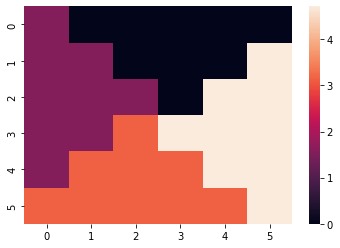

In [69]:
vortex_rads = np.zeros((6,6))
d = 3
for val in [pi * 1.5, pi, pi * .5, 0]:
    for x,y in product(range(6), range(6)):
        if y - d >= abs(x - d): 
            vortex_rads[x,y] = val
    vortex_rads = np.rot90(vortex_rads)
sns.heatmap(vortex_rads)

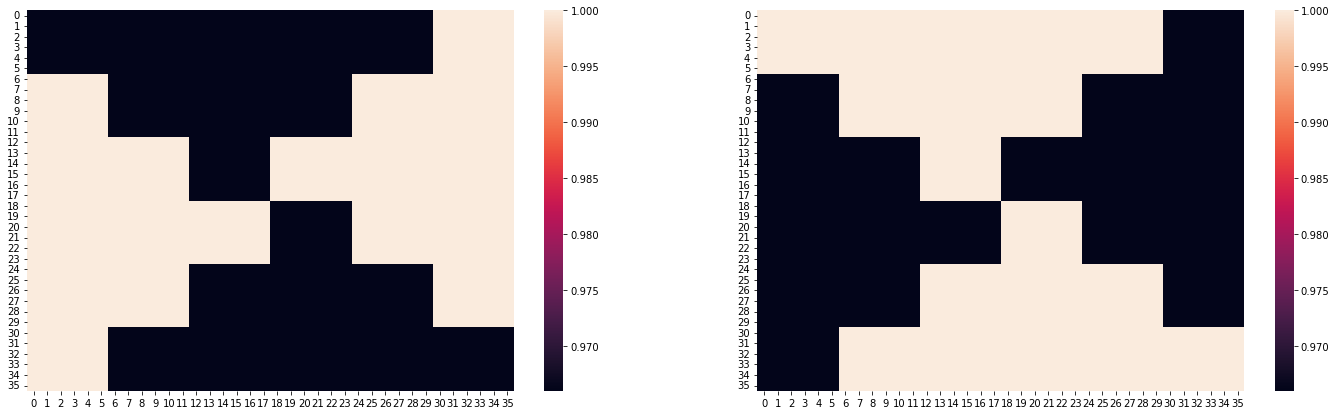

In [70]:
center = mp.Vector3(0,0,0)
size = mp.Vector3(10,10,0)
bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],7)

def eps_function(p):
    p =  p - center
    x,y = p.x,p.y
    sx, sy = size.x, size.y
    x = np.digitize(x,bins[:,0],right=False)
    y = np.digitize(y,bins[:,1],right=False)
    x = np.clip(x, 1, 6) - 1
    y = np.clip(y, 1, 6) - 1
    
    # dx,dy = size.x / 6, size.y / 6
    # x,y = round_multiple(x,max_x/3),round_multiple(y,max_y/3), 

    # angle = np.arctan2(y, x) * 180 / np.pi 
    # angle = round_multiple(angle, pi/2)
    
    # eps_1 = vortex_rads[x,y] * 180 / pi
    eps_1 = 1 - k_0 * np.sin(vortex_rads[x,y]) ** 2 # first eps (for Ex)
    # eps_3 = vortex_rads[x,y] * 180 / pi
    eps_3 = 1 - k_0 * np.cos(vortex_rads[x,y]) ** 2 # middle eps (for Ey)
    eps_4 = 1 # last eps (For Ez)
    return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
    # return mp.Medium(epsilon_diag=(2, 2, 2))

res = 36
# res = 18
xx,yy = np.meshgrid(
    np.linspace(-5,5,res),
    np.linspace(-5,5,res),
    indexing='xy'
)
out = np.zeros((res,res,3))
for i in range(res):
    for j in range(res):
        loc = mp.Vector3(xx[i,j],yy[i,j])
        out[i,j,:] = np.array(eps_function(loc).epsilon_diag)


plt.figure(figsize=(24,7))
for i in range(2):
    plt.subplot(1,2,i + 1)
    # plt.imshow(out[...,i])
    sns.heatmap(out[...,i], )#annot=True, fmt=".1e", annot_kws={"fontsize":4})
    # plt.colorbar()

In [71]:
from functools import partial
mp.verbosity.set(0)


W,H, _ = grid_size
D = pml_depth

sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=lamd,),
        component=mp.Hz, #  NOTE: Direction matters!
        size=mp.Vector3(W - D * 2 , 0, 0),
        center=mp.Vector3(0, H/2 - D - h * .5, 0)
    )
]

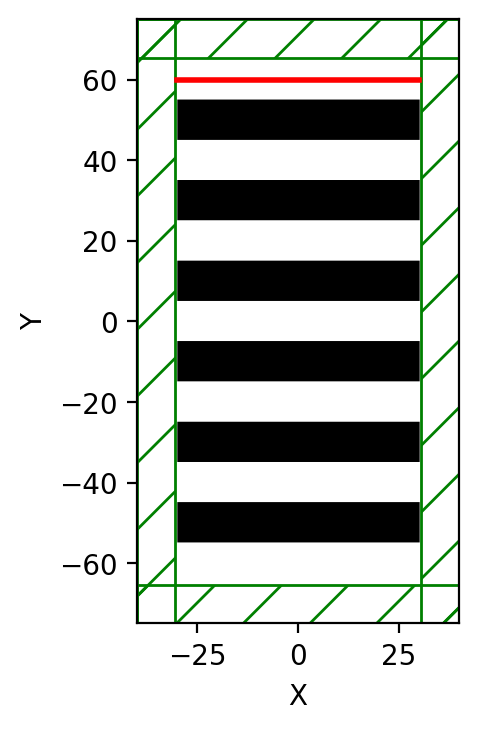

In [72]:
bl = mp.Block(
    size=size,
    center=center,
    material=eps_function
)

geometry = []
z = None
def make_eps_function_at(center, size):
    bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],7)
    def eps_function(p):
        # global z
        # z = p,center
        x,y = p.x - center.x, p.y - center.y
        x = np.digitize(x,bins[:,0],right=False)
        y = np.digitize(y,bins[:,1],right=False)
        x = np.clip(x, 1, 6) - 1
        y = np.clip(y, 1, 6) - 1
        eps_1 = 1 + k_0 * np.sin(vortex_rads[x,y]) ** 2 # first eps (for Ex)
        eps_3 = 1 + k_0 * np.cos(vortex_rads[x,y]) ** 2 # middle eps (for Ey)
        eps_4 = 1 # last eps (For Ez)
        return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
    return eps_function

for row in range(6):
    for col in range(6):
        size = mp.Vector3(10,10,0)
        center = mp.Vector3(
            D + h/2 + col * h - W / 2, D + h*1.5 +  2*h*row - H/2, 0
        )
        bl = mp.Block(
            size=size,
            center=center,
            # material=eps_function,
            material=make_eps_function_at(center, size)
        )
        geometry.append(bl)

pml_layers = [mp.PML(pml_size)]
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    geometry_center=mp.Vector3(0,0,0),
    sources=sources,
    resolution=resolution,
    Courant=courant,
    eps_averaging=True,
)
# sim.run(until=1)

plt.figure(dpi=200)
plt.subplot(121)
sim.plot2D()
plt.show()

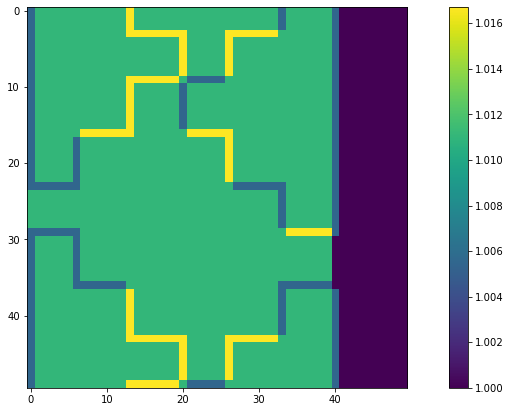

In [73]:
sim.init_sim()
z = sim.get_epsilon()
plt.figure(figsize=(15,7))
plt.imshow(z[50:100,80:130])
plt.colorbar()

## Animation

In [74]:
sim.reset_meep()
f = plt.figure()
anim = mp.Animate2D(sim, fields=mp.Hz, f=f, realtime=False, normalize=True)
plt.close()

In [75]:
import os
os.makedirs('outputs',exist_ok=True)
!rm -rf eps*h5
!rm -rf hz.h5
vals = []
# center = mp.Vector3(
#             D + h/2 + col * h - W / 2, D + h*1.5 +  2*h*row - H/2, 0
#         )
def get_slice(sim):
    vals.append(
        sim.get_array(
            center=mp.Vector3(0,h/2+D-W/2,0), 
            size=mp.Vector3(W,0,0),
            component=mp.Hz))

sim.run(
    # mp.at_beginning(mp.output_epsilon),
    # mp.to_appended("hz",mp.at_every(4, mp.output_hfield_z)),
    mp.at_every(4,anim),
    # mp.at_every(4,get_slice),
    until=500,
)

FloatProgress(value=0.0, description='0% done ', max=500.0)

In [76]:
# plt.figure()
# plt.imshow(vals, interpolation='spline36', cmap='RdBu')
# plt.axis('off')
# plt.show()

In [77]:
# !h5topng -t 0:125 \
# -R -Zc dkbluered \
# -a yarg \
# -A eps-000121.38.h5 hz.h5
# !h5ls hz.h5

In [78]:
os.makedirs('media/',exist_ok=True)
filename = f"media/k0_{k_0:.3f}.mp4"
anim.to_mp4(10,filename)

In [79]:
from IPython.display import Video
Video(filename)